<a href="https://colab.research.google.com/github/XinpeiMa/My_NoteBook/blob/master/APM_DataProject_XinpeiMa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APM Data Project

Student: Xinpei Ma (N16678739)

## (0) Data pre-processing
- adjust datatype
- sort date
- count unique tickers

In [0]:
import pandas as pd
import numpy as np
import random
from functools import reduce
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import minimize
random.seed(30)
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(15,9))
%pylab inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Parameters
path = "drive/My Drive/My Classes/APM/DataProject/prices.csv"
annual_r = 0.015
r = (annual_r + 1) ** (1. / 365.) - 1. # daily risk-less rate of return

In [0]:
def change_str_to_float(x):
    if x == ".":
        return 0.
    return float(x)

In [0]:
df = pd.read_csv(path, header=0)
df = df.loc[df.PRC != 'PRC', :]
df['TICKER'] = df['TICKER'].astype(str)
df['date'] = df['date'].astype(str)
df['PRC'] = df['PRC'].apply(lambda x: change_str_to_float(x))
df['VOL'] = df['VOL'].apply(lambda x: change_str_to_float(x))
tickers = df.TICKER.unique().tolist()
df.set_index('date', inplace=True)
df.date = df.index
df['Date'] = pd.to_datetime(df.date)
df.sort_values(by='Date')
print(df.TICKER.unique().tolist())
print(len(df.TICKER.unique().tolist()))

## (1) compute $v_t$ signal

#### Rolling window out-of-sample forecasting

- In order to compute $\beta$, I implemented a rolling window out-of-sample approach that using a fixed number of the most recent data（i.e., 66 days) at each point of time. I examined the variance and bias value of applying different window size. Finally, I found that window size 66 yielded the best result (with minimal total error). 

- The beta that we get from regressing of asset's returns on the returns of the market represents the sensitivity of an asset's return stream to market-wide shocks, therefore $v_t$ represents a signal of stock idiosyncratic risk signal.


In [0]:
def calc_residual_reversion_signal(tk, df, window_size, r):
    SPY = df.loc[df['TICKER'] == 'SPY', ['PRC', 'VOL']]
    SPY.columns = ["SPY_PRC", "SPY_VOL"]
    Stock = df.loc[df['TICKER'] == tk, ['PRC', 'VOL']]
    merged = pd.merge(left=SPY, right=Stock, right_index=True, left_index=True, how='outer')
    merged['stock_ret'] = np.log(merged.PRC) - np.log(merged.PRC.shift(1))
    merged['market_ret'] = np.log(merged.SPY_PRC) - np.log(merged.SPY_PRC.shift(1))
    cov = merged.stock_ret.rolling(window_size).cov(merged.market_ret.rolling(window_size))
    var = merged.market_ret.rolling(window_size).var()
    merged['beta'] = cov / var
    merged['temp'] = merged['stock_ret'] - merged['market_ret'] * merged['beta']
    merged['vt'] = merged['temp'].shift(1)
    merged.drop(columns=['temp'], inplace=True)
    return merged

#### Find Optimal Rolling Window Size by Checking out-of-sample Variance and Bias

In [0]:
windows = [22, 66, 132, 154, 176, 225, 500]
bias_list = []
variance_list = []
for i in range(len(windows)):
    print("Windows {} days".format(windows[i]))
    bias_res = 0.0
    var_res = 0.0
    count = 0
    for ticker in tickers:
        if ticker != 'SPY':
            residual_reversion_df = calc_residual_reversion_signal(ticker, df, windows[i], r)
            residual_reversion_df = residual_reversion_df.loc[residual_reversion_df['vt'].notnull(), :]

            pred = residual_reversion_df['market_ret'] * residual_reversion_df['beta']
            real = residual_reversion_df['stock_ret']
            variance = np.mean(np.square(pred - pred.mean()))
            # sum(real - E[predictced])^2
            bias = np.mean(np.square(real - pred.mean()))
            # sum(predicted - E[predictced])^2
            if np.isfinite(variance) and np.isfinite(bias):
                bias_res += bias
                var_res += variance
                count += 1

    variance_list.append(var_res/count)
    bias_list.append(bias_res/count)
    

In [0]:
print(bias_list, variance_list)
plot_df = pd.DataFrame({"bias": bias_list, "variance": variance_list}, index=[str(x) + "d" for x in windows])
plot_df['total_error'] = plot_df.bias + plot_df.variance
print(plot_df)
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(plot_df.bias, 'o-', linewidth=2, markersize=6, label="bias", alpha=0.5)
ax.plot(plot_df.variance, 'o-', linewidth=2, markersize=6, label='variance', alpha=0.5)
ax.plot(plot_df.total_error, 'o-', linewidth=2, markersize=6, label='total error')
ax.plot(1, plot_df.total_error.min(), marker='o', markersize=6, color="red", label='minimal')
ax.set_xticklabels(plot_df.index.tolist())
ax.legend()
plt.show()

From the above experiment, we select rolling window size 132 days, because it seems like the best variance-bias trade-off.

In [0]:
rolling_window = 66

#### An example of $v_t$ signal computed using 66 days rolling window

In [0]:
stock_signal_df = calc_residual_reversion_signal("IBM", df, rolling_window, r)
display(stock_signal_df)

#### Does $v_t^1$ predict $r_{t, t+1}^i$ and $r_{t+1, t+2}^i$ etc.?

I checked the $R^2$ and $p$ value between $v_t^1$ and $r_{t, t+1}^i$ and the  $R^2$ and $p$ between $v_t^1$ and $r_{t+1, t+2}^i$

In [0]:
def measure_predictive_capacity(df, x, y, time_lag):
	# if paired x, y if any value in x or y is none then exclude it
	def remove_nan(x, y):
		pairs = []
		for i in range(len(x)):
			if np.isnan(x[i]) or np.isnan(y[i]):
				continue
			pairs.append((x[i], y[i]))
		return pairs
		
    # test on out-of-sample part
	out_sample = df.loc[df[y].notnull(), :]
	out_sample['shift'] = out_sample.loc[:, x].shift(periods=time_lag)
	xy = remove_nan(np.array(out_sample['shift'].values, dtype=np.float64), 
                    np.array(out_sample[y].values, dtype=np.float64))
	if len(xy) > 10:
		model = sm.OLS([i[0] for i in xy], [i[1] for i in xy])
		results = model.fit()
		return results.rsquared, results.pvalues[0]
	return None, None

In [0]:
df_map = {}
for ticker in tickers:
    stock_signal_df = calc_residual_reversion_signal(ticker, df, rolling_window, r)
    df_map[ticker] = stock_signal_df
print(df_map.keys())

In [0]:
time_lag_1, time_lag_2 = -1, -2
time_lag_dependency_results = {}

for ticker in tickers:
    if ticker != 'SPY':
        res = {}
        stock_signal_df = df_map[ticker]
        r_square_1, p_value_1 = measure_predictive_capacity(stock_signal_df, 'stock_ret', 'vt', time_lag_1)
        r_square_2, p_value_2 = measure_predictive_capacity(stock_signal_df, 'stock_ret', 'vt', time_lag_2)
        
        if len((stock_signal_df['beta'].values.tolist())) > 1:
            res['beta'] = stock_signal_df['beta'].values.tolist()[-1]
            res['lag_1_rsquare'] = r_square_1
            res['lag_1_pvalue'] = p_value_1
            res['lag_2_rsquare'] = r_square_2
            res['lag_2_pvalue'] = p_value_2

        time_lag_dependency_results[ticker] = res
    

data = []
for k, v in time_lag_dependency_results.items():
    data.append([k] + list(v.values()))
res = pd.DataFrame(data,  columns = ['ticker', 'beta', '1_step_rsquare', '1_step_p', '2_step_rsquare', '2_step_p']) 
res = np.round(res, decimals=2)

print(time_lag_dependency_results)

In [0]:
print(res.loc[:, ['1_step_rsquare', '1_step_p', '2_step_rsquare', '2_step_p']].describe())

- From the statistic results, I found that the generated signal $v_t$ doesnt have significantly association between future returns (lag 1 and lag 2) based on the observation that the average $p$ value is very high (around 0.2). 
- The association between 
 $v_t$ and $r_{t+1}$ is usually very close to the association between $v_t$ and $r_{t+2}$. Slideghtly larger $R^2$ of $v_t$ and $r_{t+2}$ indicate the mean-reverting pattern.

## (2) Create the corresponding Markowitz portfolio and track its performance

#### Basic Assumptions: 
- We assumed that investors are able to trade without delay or cost.
- We assumed that all investors are "mean-variance optimizers". What this essentially means is that they would only 
demand portfolios that have the highest return attainable for a given level of risk. 
- Here, I only consider long only portfolio in order to simplify borrow/lend procedure.

Data Preparation for Portfolio Construction

In [0]:
selected_df_list = []
for ticker in df_map.keys():
    temp_df = df_map[ticker]
    temp_df_vt = temp_df.loc[temp_df['vt'].notnull(), ['stock_ret', 'beta', 'vt', 'PRC', 'VOL']].copy()
    temp_df_vt = temp_df_vt.loc[~temp_df_vt.index.duplicated(keep='first')]
    temp_df_vt.columns = [ticker + '_ret', ticker + '_beta', ticker + '_vt', ticker + "_prc", ticker + "_vol"]
    selected_df_list.append(temp_df_vt)
vt_df = reduce(lambda x, y: pd.merge(x, y, left_index=True, right_index=True, how='outer'), selected_df_list)
print(vt_df.columns)
print("{} of stocks are included".format(len(selected_df_list)))

In [0]:
SPY_var = df.loc[df.TICKER == "SPY", 'PRC'].rolling(rolling_window).var()
SPY_mean = df.loc[df.TICKER == "SPY", 'PRC'].rolling(rolling_window).mean()
SPY_ = pd.concat([SPY_mean, SPY_var], axis=1)
SPY_.columns = ['SPY_mean', 'SPY_var']

In [0]:
portfolio_prep_df = vt_df.merge(SPY_, left_index=True, right_index=True, how='left')
prep_cols = portfolio_prep_df.columns
for col in prep_cols:
    if col[-3:] == '_vt':
        portfolio_prep_df[col + '_var'] = portfolio_prep_df[col].rolling(rolling_window).var()
portfolio_prep_df = portfolio_prep_df.drop_duplicates()

In [0]:
all_dates = portfolio_prep_df.index.unique().tolist()

Based on our slides, we compute the risk tolerance as
$\kappa_M = \frac{\mathbb{E}R_M -  \mu_0}{\mathbb{Var} R_M}$.
Weights $w$ satisfies constrained $\sum_i{w_i} =1$ and $w_i \in [0, 1]$.


In [0]:
def compute_covariance(date, prep_df):
    vt_vars, betas, returns, included_tickers = [], [], [], []

    for tk in df_map.keys():
        try:
            beta, vt_var, ret = prep_df.at[date, tk + '_beta'], \
                                prep_df.at[date, tk + '_vt_var']/rolling_window, \
                                prep_df.at[date, tk + '_ret']
            if np.isfinite(beta) and np.isfinite(vt_var) and np.isfinite(ret):
                betas.append(beta)
                vt_vars.append(vt_var)
                returns.append(ret)
                included_tickers.append(tk)
        except:
            continue

    betas = np.array(betas).reshape(-1, 1)
    SPY_var = prep_df.at[date, 'SPY_var'] / rolling_window
    cov = betas.dot(betas.transpose()) * SPY_var + np.diag(np.array(vt_vars))
    return [cov, np.array(returns), included_tickers]

In [0]:
def get_markovitz_weights(date, prep_df, r):
    cov, rets, tks = compute_covariance(date, prep_df)
    risk_adjusted_returns = np.array(rets) - np.ones(len(rets)) * r
    SPY_var = prep_df.at[date, 'SPY_var'] / rolling_window
    kappa = (prep_df.at[date, 'SPY_mean'] - r)/ SPY_var
    def objective(w):
        return 0.5 * kappa * w.transpose().dot(cov).dot(w) - np.dot(w, risk_adjusted_returns) 

    w0 = [1.0/len(risk_adjusted_returns) for _ in range(len(risk_adjusted_returns))]
    e = np.ones(len(risk_adjusted_returns))
    bnds = [(0., 1.) for _ in range(len(risk_adjusted_returns))]
    const = ({'type': 'eq', 'fun': lambda w: np.dot(w, e) - 1.})
    try:
        solution = minimize(fun=objective, x0=w0, method='SLSQP', bounds=bnds, constraints=const)
        w = solution.x.round(6)
    except:
        w = None
    return tks, w

In [0]:
def get_next_day(date):
    curr_index = all_dates.index(date)
    return all_dates[curr_index + 1] if curr_index + 1 < len(all_dates) else None

In [0]:
def calc_portfolio_ret(date, weights, tks, df):
    rets = []
    for tk in tks:
        rets.append(df.at[date, tk + "_ret"])
    portfolio_return = np.array(rets).dot(weights)
    return portfolio_return

In [0]:
def MDD(xs):
    # maximum drawdown
    i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
    j = np.argmax(xs[:i]) # start of period
    return abs(xs[i]-xs[j])

In [0]:
def track_portfolio_performance(start_date_index, end_date_index):
    pnl = 100.
    ret = None
    portfolio_history = {}
    pnl_list = [100.]
    for i in range(start_date_index, end_date_index):
        curr_day = all_dates[i]
        next_day = get_next_day(curr_day)
        markovitz_rs = get_markovitz_weights(curr_day, portfolio_prep_df, r)

        if markovitz_rs[1] is not None:
            curr_tickers, curr_weights = markovitz_rs[0], markovitz_rs[1]
            ret = calc_portfolio_ret(next_day, curr_weights, curr_tickers, portfolio_prep_df)
            if i == start_date_index:
                portfolio_history[curr_day] = [ret, pnl, 0.]
        if not np.isfinite(ret):
            ret = 0.
        pnl *= np.exp(ret)
        pnl_list.append(pnl)
        try:
            portfolio_history[next_day] = [ret, pnl, MDD(pnl_list)]
        except:
            portfolio_history[next_day] = [ret, pnl, 0]

    return portfolio_history

#### Three Experiments
Since we have complete out-of-sample data for 2009, 2010 and 2011 due to the rolling window approach. Data for 2008 is not quite complete due to the rolling window procedure.
We keep track of the monthly portfolio for the three years.

In [0]:
def find_montly_index(year):
    monthly_index = {}
    for i in range(len(all_dates)):
        if all_dates[i][:4] == year:
            if all_dates[i][4:6] not in monthly_index:
                monthly_index[all_dates[i][4:6]] = []
            monthly_index[all_dates[i][4:6]].append(i)
    return monthly_index

In [0]:
index_2009 = find_montly_index('2009')
print(index_2009)
res_2009 = dict()
for mo in index_2009.keys():
    start, end = min(index_2009[mo]), max(index_2009[mo])
    portfolio = track_portfolio_performance(start, end)
    portfolio_df = pd.DataFrame.from_dict(portfolio, orient='index')
    portfolio_df.columns = ["ret", "pnl", 'mmd']
    res_2009[mo] = []
    res_2009[mo].append(portfolio_df['ret'].mean() - r)
    res_2009[mo].append(portfolio_df['ret'].std()/np.sqrt(len(index_2009[mo])))
    res_2009[mo].append(portfolio_df['mmd'].max())

In [27]:
df_2009_1 = pd.DataFrame(res_2009, index=['average excess returns', 'vol', 'mmd']).T
df_2009_1['sharpe ratio'] = df_2009_1['average excess returns'] / df_2009_1['vol']
display(df_2009_1)
display(df_2009_1.describe())

,average excess returns,vol,mmd,sharpe ratio
01,0.579969,0.151852,2.300242,3.819312
02,0.599056,0.100263,0.000000,5.974827
03,0.814004,0.129195,0.000000,6.300593
04,0.185003,0.127062,28.830281,1.456007
05,0.001815,0.003053,4.610837,0.594688
06,0.266027,0.118339,4.073553,2.247997
07,0.328838,0.112796,2588.760492,2.915347
08,0.001944,0.003631,4.789287,0.535493
09,0.001999,0.002052,3.545142,0.974331
10,0.078771,0.076717,8.289380,1.026775


,average excess returns,vol,mmd,sharpe ratio
count,12.000000,12.000000,12.000000,12.000000
mean,0.244311,0.072148,221.506930,2.357648
std,0.280621,0.058446,745.530035,2.034912
min,0.001492,0.002052,0.000000,0.530647
25%,0.001986,0.003486,3.233917,0.879420
50%,0.131887,0.088490,4.606542,1.685883
75%,0.391621,0.120520,8.283617,3.141339
max,0.814004,0.151852,2588.760492,6.300593


In [0]:
index_2010 =  find_montly_index('2010')
res_2010 = dict()
for mo in index_2010.keys():
    start, end = min(index_2010[mo]), max(index_2010[mo])
    portfolio = track_portfolio_performance(start, end)
    portfolio_df = pd.DataFrame.from_dict(portfolio, orient='index')
    portfolio_df.columns = ["ret", "pnl", 'mmd']
    res_2010[mo] = []
    res_2010[mo].append(portfolio_df['ret'].mean() - r)
    res_2010[mo].append(portfolio_df['ret'].std())
    res_2010[mo].append(portfolio_df['mmd'].max())

In [29]:
df_2010_1 = pd.DataFrame(res_2010, index=['average excess returns', 'vol', 'mmd']).T
df_2010_1['sharpe ratio'] = df_2010_1['average excess returns'] / df_2010_1['vol']
display(df_2010_1)
display(df_2010_1.describe())

,average excess returns,vol,mmd,sharpe ratio
01,0.100665,0.188038,4.917541,0.535342
02,0.364856,0.177507,0.000000,2.055448
03,0.164005,0.237528,5.448070,0.690466
04,0.057889,0.036113,1.688045,1.602993
05,0.544171,0.787888,65.577764,0.690671
06,0.297073,0.149229,0.000000,1.990718
07,0.640515,1.231943,825335.503709,0.519923
08,0.098921,0.200674,3.148638,0.492943
09,0.415016,1.448861,16356.995460,0.286443
10,0.052936,0.038108,2.027311,1.389102


,average excess returns,vol,mmd,sharpe ratio
count,12.000000,12.000000,12.000000,12.000000
mean,0.233201,0.381124,70148.429622,0.988438
std,0.213737,0.494164,237868.684789,0.619752
min,0.021103,0.036113,0.000000,0.286443
25%,0.056651,0.038802,1.655338,0.531487
50%,0.132335,0.182772,3.720176,0.690569
75%,0.377396,0.375118,20.480494,1.442575
max,0.640515,1.448861,825335.503709,2.055448


In [0]:
index_2011 =  find_montly_index('2011')
print(index_2011)
res_2011 = dict()
for mo in index_2011.keys():
    start, end = min(index_2011[mo]), max(index_2011[mo])
    portfolio = track_portfolio_performance(start, end)
    portfolio_df = pd.DataFrame.from_dict(portfolio, orient='index')
    portfolio_df.columns = ["ret", "pnl", 'mmd']
    res_2011[mo] = []
    res_2011[mo].append(portfolio_df['ret'].mean() - r)
    res_2011[mo].append(portfolio_df['ret'].std()/np.sqrt(len(index_2011[mo])))
    res_2011[mo].append(portfolio_df['mmd'].max())

In [31]:
df_2011_1 = pd.DataFrame(res_2011, index=['average excess returns', 'vol', 'mmd']).T
df_2011_1['sharpe ratio'] = df_2011_1['average excess returns'] / df_2011_1['vol']
display(df_2011_1)
display(df_2011_1.describe())

,average excess returns,vol,mmd,sharpe ratio
01,0.068662,0.005571,0.000000e+00,12.324469
02,0.062044,0.007749,1.201352e+00,8.007226
03,0.624013,0.139111,0.000000e+00,4.485710
04,0.638935,0.161018,0.000000e+00,3.968086
05,0.222071,0.081479,6.026495e-01,2.725489
06,0.105015,0.020075,2.388797e+00,5.231095
07,0.679151,0.333670,3.740290e+06,2.035397
08,0.474814,0.102887,0.000000e+00,4.614923
09,0.656541,0.121138,4.159798e+04,5.419764
10,0.270430,0.154576,5.210281e+02,1.749488


,average excess returns,vol,mmd,sharpe ratio
count,12.000000,12.000000,1.200000e+01,12.000000
mean,0.413475,0.139696,2.267245e+07,4.523077
std,0.296569,0.118685,7.735597e+07,3.114710
min,0.062044,0.005571,0.000000e+00,1.237305
25%,0.176272,0.066128,0.000000e+00,2.367333
50%,0.372622,0.130125,1.795075e+00,4.226898
75%,0.643336,0.161179,1.079027e+04,5.278262
max,0.960004,0.387414,2.682870e+08,12.324469


## (3) Consider Market Impact

- Define market impact model
$\text{cost} = \alpha \left| \Delta w_t \right|^2 +  \beta \sigma \sqrt{\frac{Q}{T} }$
where  $Q$ is the number of shares to be traded, $V$ is daily volume. Both $\alpha$ and $\beta$ are two constant parameters, $\alpha$ represents the fixed cost per share, and $\beta$ is the coefficient expressing the liquidity of the stock.

 
- The objective function can be formulated as
$\max_w \mathbb{E}(w R) - \frac{\kappa}{2} \mathbb{Var} (w R) - \alpha \left| \Delta w_t \right|^2  - \beta \sigma \sqrt{\frac{Q}{T} }$. The first tem is expected returns, the second term is risk-aversion, the third term is a fixed cost for Bid/Ask spread and the last term is a dynamic term of market impact. In general the last two terms serve as important component of trading cost.

- Based on our knowledge about around 1 percent is the average impact cost for US large-cap stocks. We can guess the value of $\alpha = 0.1 $ and $\beta = 10$.


#### Visualize Market Impact Curve and Guess Parameters $\alpha$ and $\beta$



[0.10461963992418803, 0.11460858413028173, 0.14619639924188021, 0.24608584130281724, 0.5619639924188021, 1.5608584130281724, 4.71963992418802, 14.708584130281725, 46.296399241880216, 146.18584130281724, 462.0639924188022, 1460.9584130281723, 4619.739924188021, 14608.684130281725, 46196.49924188021, 146085.94130281726, 461964.0924188021, 1460858.5130281725, 4619640.024188021, 14608584.230281724]


Text(0.5, 1.0, 'simulated market impact curve (x:shares, y:market_impact)')

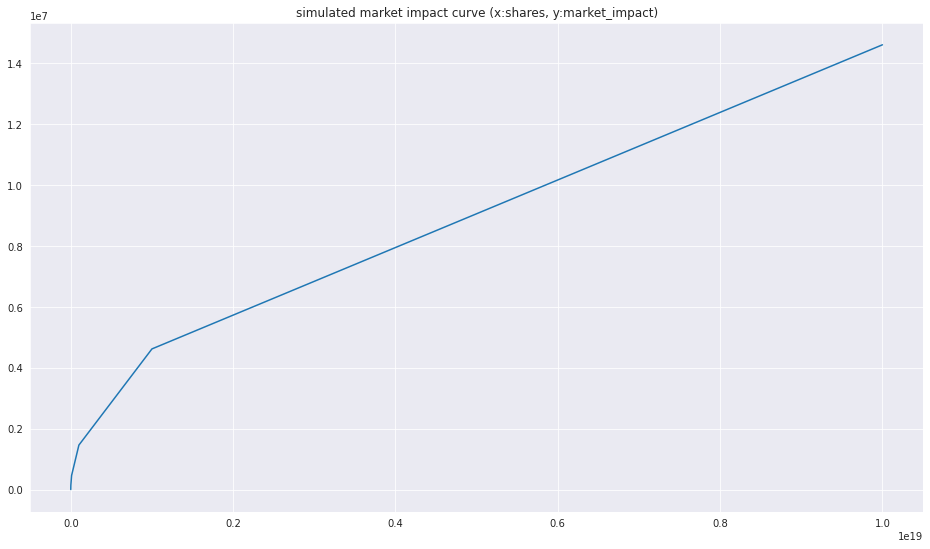

In [32]:
def market_impact_test():
    shares = [10**i for i in range(20)]
    test_date = '20121231'
    # assume we long trade ibm, with different shares
    ibm_price = stock_signal_df.at[test_date, 'PRC']
    volume = stock_signal_df.at[test_date, 'VOL']
    weight_change = 1
    market_impact_res = []
    for s in shares:
        market_impact = 0.1 * weight_change ** 2 +  10 * np.sqrt(s / volume)
        market_impact_res.append(market_impact)
    return shares, market_impact_res

stock_signal_df = calc_residual_reversion_signal("IBM", df, rolling_window, r)
x, y = market_impact_test()
print(y)
plt.rcParams["figure.figsize"] = (16,9)
plt.plot(x, y)
plt.title('simulated market impact curve (x:shares, y:market_impact)')

In [0]:
def get_total_market_volume(date, tks, prep_df):
    overall_volume = 0.0
    for tk in tks:
        overall_volume += max(abs(prep_df.at[date, tk + '_prc'] * prep_df.at[date, tk + '_vol']), 0.0)
    return overall_volume

In [0]:
def get_weight_change(w, prev_w):
    weight_delta = 0.0
    n = len(w)
    if prev_w is None:
        for i in range(n):
            weight_delta += abs(w[i])
    else:
        for i in range(n):
            try:
                if np.sign(w[i]) == np.sign(prev_w[i]):
                    weight_delta += abs(w[i] - prev_w[i])
                else:
                    weight_delta += abs(w[i]) + abs(prev_w[i])
            except:
                pass
    return weight_delta

In [0]:
def markovitz_plus_market_impact_weights(date, prep_df, r, pnl, prev_w):
    # all avaiable trading for curr date
    cov, rets, tks = compute_covariance(date, prep_df) 
    adj_returns = np.array(rets) - np.ones(len(rets)) * r
    SPY_var = prep_df.at[date, 'SPY_var'] / rolling_window
    kappa = (prep_df.at[date, 'SPY_mean'] - r) / SPY_var


    def objective(w):
        weight_change = get_weight_change(w, prev_w)
        market_impact = 0.1 * weight_change ** 2 + 10 * np.sqrt((pnl * weight_change) / get_total_market_volume(date, tks, prep_df))
        return 0.5 * kappa * w.transpose().dot(cov).dot(w) + market_impact - np.dot(w, adj_returns)

    w0 = [1.0 / len(rets) for _ in range(len(rets))]
    e = np.ones(len(rets))
    bnds = [(0, 1) for _ in range(len(rets))]
    const = ({'type': 'eq', 'fun': lambda w: np.dot(w, e) - 1.})
    solution = minimize(fun=objective, x0=w0, method='SLSQP', bounds=bnds, constraints=const)
    w = solution.x.round(6)

    return w, tks



def calc_portfolio_returns(date, w, tks, df):
    rets = []
    for tk in tks:
        try:
            rets.append(df.at[date, tk + "_ret"])
        except:
            rets.append(0.0)
    portfolio_return = np.array(rets).dot(w)
    return portfolio_return



def track_portfolio_performance_1(start, end, prep_df=portfolio_prep_df, daily_r=r):
    pnl = 100.
    portfolio_history = {}
    prev_w = None
    pnl_list =[100.]

    for i in range(start, end):
        curr_day = all_dates[i]
        next_day = get_next_day(curr_day)

        if i == start:
            portfolio_history[curr_day] = [0.0, pnl]

        w, tks = markovitz_plus_market_impact_weights(next_day, prep_df, daily_r, pnl, prev_w)
        portfolio_ret = calc_portfolio_returns(next_day, w, tks, prep_df)
        pnl += pnl * portfolio_ret
        pnl_list.append(pnl)
        try:
            portfolio_history[next_day] = [portfolio_ret, pnl, MDD(pnl_list)]
        except:
            portfolio_history[next_day] = [portfolio_ret, pnl, 0]
        prev_w = w

    return portfolio_history

In [0]:
index_2009 =  find_montly_index('2009')
res_2009_mi = dict()
for mo in index_2010.keys():
    start, end = min(index_2009[mo]), max(index_2009[mo])
    portfolio = track_portfolio_performance_1(start, end)
    portfolio_df = pd.DataFrame.from_dict(portfolio, orient='index')
    portfolio_df.columns = ["ret", "pnl", "mmd"]
    res_2009_mi[mo] = []
    res_2009_mi[mo].append(portfolio_df['ret'].mean() - r)
    res_2009_mi[mo].append(portfolio_df['ret'].std())
    res_2009_mi[mo].append(portfolio_df['mmd'].max())


In [37]:
df_2009_2 = pd.DataFrame(res_2009_mi, index=['average excess returns', 'vol', 'mmd']).T
df_2009_2['sharpe ratio'] = df_2009_2['average excess returns'] / df_2009_2['vol']
display(df_2009_2)
display(df_2009_2.describe())

,average excess returns,vol,mmd,sharpe ratio
01,0.599312,0.669534,0.887094,0.895118
02,0.565681,0.477831,0.000000,1.183852
03,0.923587,0.606020,0.000000,1.524020
04,0.000047,0.010995,4.157847,0.004254
05,0.002138,0.013117,4.598813,0.163023
06,0.268127,0.548299,3.001016,0.489016
07,0.330402,0.527948,243.970251,0.625824
08,0.004129,0.019093,5.447585,0.216250
09,0.002594,0.009642,3.561886,0.268981
10,0.093735,0.361631,3.924282,0.259200


,average excess returns,vol,mmd,sharpe ratio
count,12.000000,12.000000,12.000000,12.000000
mean,0.236115,0.285660,27.144831,0.500014
std,0.309665,0.270488,69.715319,0.471455
min,0.000047,0.009642,0.000000,0.004254
25%,0.002480,0.013196,2.472535,0.202943
50%,0.067858,0.266107,4.041064,0.264090
75%,0.389222,0.533035,4.855826,0.693147
max,0.923587,0.669534,243.970251,1.524020


In [0]:
index_2010 =  find_montly_index('2010')
res_2010_mi = dict()
for mo in index_2010.keys():
    start, end = min(index_2010[mo]), max(index_2010[mo])
    portfolio = track_portfolio_performance_1(start, end)
    portfolio_df = pd.DataFrame.from_dict(portfolio, orient='index')
    portfolio_df.columns = ["ret", "pnl", "mmd"]
    res_2010_mi[mo] = []
    res_2010_mi[mo].append(portfolio_df['ret'].mean() - r)
    res_2010_mi[mo].append(portfolio_df['ret'].std())
    res_2010_mi[mo].append(portfolio_df['mmd'].max())


In [39]:
df_2010_2 = pd.DataFrame(res_2010_mi, index=['average excess returns', 'vol', 'mmd']).T
df_2010_2['sharpe ratio'] = df_2010_2['average excess returns'] / df_2010_2['vol']
display(df_2010_2)
display(df_2010_2.describe())

,average excess returns,vol,mmd,sharpe ratio
01,0.095299,0.174911,2.935795,0.544841
02,0.377184,0.218718,0.000000,1.724522
03,0.117354,0.200222,2.177367,0.586120
04,0.054355,0.038473,2.380253,1.412821
05,0.559175,0.790967,0.000000,0.706951
06,0.288905,0.164796,0.000000,1.753113
07,0.643639,1.232553,1616.555324,0.522200
08,0.102080,0.178370,2.694840,0.572297
09,0.412762,1.446538,66.820408,0.285345
10,0.041210,0.041743,1.421108,0.987225


,average excess returns,vol,mmd,sharpe ratio
count,12.000000,12.000000,12.000000,12.000000
mean,0.229966,0.380708,141.702343,0.896520
std,0.219241,0.493783,464.836980,0.487886
min,0.027661,0.038473,0.000000,0.285345
25%,0.051069,0.041560,1.065831,0.565433
50%,0.109717,0.176640,2.278810,0.697578
75%,0.386078,0.361780,3.190473,1.093624
max,0.643639,1.446538,1616.555324,1.753113


In [0]:
index_2011 =  find_montly_index('2011')
res_2011_mi = dict()
for mo in index_2011.keys():
    start, end = min(index_2011[mo]), max(index_2011[mo])
    portfolio = track_portfolio_performance_1(start, end)
    portfolio_df = pd.DataFrame.from_dict(portfolio, orient='index')
    portfolio_df.columns = ["ret", "pnl", "mmd"]
    res_2011_mi[mo] = []
    res_2011_mi[mo].append(portfolio_df['ret'].mean() - r)
    res_2011_mi[mo].append(portfolio_df['ret'].std())
    res_2011_mi[mo].append(portfolio_df['mmd'].max())

In [41]:
df_2011_2 = pd.DataFrame(res_2011_mi, index=['average excess returns', 'vol', 'mmd']).T
df_2011_2['sharpe ratio'] = df_2011_2['average excess returns'] / df_2011_2['vol']
display(df_2011_2)
display(df_2011_2.describe())

,average excess returns,vol,mmd,sharpe ratio
01,0.071318,0.026419,0.118955,2.699459
02,0.055500,0.055571,40.678996,0.998713
03,0.647886,0.701713,1.523991,0.923292
04,0.406415,0.425663,94.742012,0.954781
05,0.242507,0.381065,4.770505,0.636393
06,0.107458,0.083169,1.264135,1.292042
07,0.682397,1.488270,2847.874064,0.458517
08,0.331338,0.205018,0.000000,1.616146
09,0.613404,0.588001,325.117595,1.043202
10,0.239364,0.701875,56.080422,0.341035


,average excess returns,vol,mmd,sharpe ratio
count,12.000000,12.000000,12.000000,12.000000
mean,0.385125,0.595251,281.552493,0.984193
std,0.301966,0.549061,813.447245,0.669984
min,0.055500,0.026419,0.000000,0.260399
25%,0.167000,0.174555,1.175357,0.554384
50%,0.286923,0.506832,5.160358,0.939036
75%,0.622024,0.705792,65.745820,1.105412
max,1.037062,1.768704,2847.874064,2.699459


- After comparing the three experients of with- and without- consideration of market impact for 2009, 2010, 2011, respectively, considering the market impact results in signifcantly reduced average returns (around 20%) and increased vol (range from 0% to 50%). 
- Regarding the maximum drawdown value, after penalizing the market impact and position change reduced the significant maximum draw down sucessfully.
- The overall performance (sharpe ratio) gets worst, becasue reducing the average excess return and increased volatility are the most dominant forces.


#### Project Summary and Conclusions:


- By searching from different optimal rolling windows, I found that 66 days rolling window result in the smallest total error. When the window size gets longer, the variance decrease monotonically, but the bias increase again, because longer rolling window cannot capture the immediate changes on beta. 

- I applied the markovits mean-variance portfolio with long only constraints in order to simplify the borrow/lend procedure, I found that the performance of using residual reversion signal is very promissing. The results of 2009, 2010, and 2010 consistently indicated high returns and low variance patterns.

- In order to considering market impact, I modify the markvitz portfolio by adding two terms: 1) fixed cost for Bid/Ask spread and 2) the last term is a dynamic term of market impact. The portfolio performance changed singifcantly. The return significantly reduced (40%) and volatility significantly increased (from 0% to 50%). Consequently, the sharpe ratio reduced about half of it.

- One advantage of considering market impact is that the maximum drawdown has been succesullfy controlled. Intuitively, those maximum drawdown came from large postion change, which has been penzalized by the modified optimier.

- In the future study, it worth to collect more trading data to find-tune the parameters and improve and precision of this study. 



